In [1]:
import tensorflow as tf
import cv2
import numpy as np
import json
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [2]:

classNames =  ["NC", "WF", "MR", "IN"]
colors = [(255,0,0),(0,255,0),(0,0,255),(255,255,0)]
imagFile = r"C:\Users\z004hkut\projects\01_robotics\01_ml\project-ctchr\objectDetector\data\debug\000001.jpg"
jsonFile = r"C:\Users\z004hkut\projects\01_robotics\01_ml\project-ctchr\objectDetector\data\debug\000001.json"

img = cv2.imread(imagFile)

with open(jsonFile, "r") as f1:
    data = json.load(f1)

iw,ih = img.shape[1],img.shape[0]


boxes = np.asarray([(b["points"][0][0]/iw, b["points"][0][1]/ih, b["points"][1][0]/iw, b["points"][1][1]/ih )  for b in data["shapes"]])
labels = np.asarray([classNames.index(b["label"])  for b in data["shapes"]])
labels = np.asarray([[0 if i !=l else 1 for i in range(len(classNames))]  for l in labels]) # [N,C]


In [3]:

# ==============================
def toIdx(i,j,k,nx,ny):
    return i + nx*j + nx*ny*k

# ==============================
def toIjk(idx, nx, ny):
    i = idx % nx
    j = (idx/nx) % ny
    k = idx/(nx*ny)
    return (i,j,k)


# ==============================
def encode(boxes, labels, nx, ny):

    xx = np.stack(np.meshgrid(
        np.arange(0,nx,1),
        np.arange(0,ny,1),
    ), axis=-1)

    xx = np.expand_dims(xx,axis=2) # [H,W,1,2]

    xm = 0.5*(nx)*(boxes[:,0]+boxes[:,2]) 
    ym = 0.5*(ny)*(boxes[:,1]+boxes[:,3]) 
    bw = nx*(boxes[:,2]-boxes[:,0]) 
    bh = ny*(boxes[:,3]-boxes[:,1])


    bc = np.stack((xm,ym),axis=-1) # [N,2]
    bcTilde = (bc.astype(np.int32)).astype(np.float64) # [N,2]

    wh = np.stack((bw,bh),axis=-1) # [N,2]
  
    # =======================================
    sigma = 0.03*np.sqrt(nx*ny)

    hm = np.exp( np.sum( - 0.5* (xx-np.expand_dims(np.expand_dims(bcTilde,0),0))**2 / (sigma**2), axis=-1)) # [H,W,N]
    hm = np.amax(np.expand_dims(hm,-1)*labels, axis=2)

    pmap = np.zeros((ny,nx,2))
    wmap = np.zeros((ny,nx,2))

    for n,idx in enumerate(bcTilde.astype(np.int32)):
        pmap[idx[1],idx[0],:] = (bc[n,:]-bcTilde[n,:])
        wmap[idx[1],idx[0],:] = np.log1p(wh[n,:])


    return np.concatenate((hm,wmap,pmap),axis=-1)



In [4]:
# ===============================================
def _gaussian_radius(height, width, min_overlap=0.7):
    a1 = 1.
    b1 = (height + width)
    c1 = width * height * (1. - min_overlap) / (1. + min_overlap)
    sq1 = tf.sqrt(b1 ** 2. - 4. * a1 * c1)
    r1 = (b1 + sq1) / 2.

    a2 = 4.
    b2 = 2. * (height + width)
    c2 = (1. - min_overlap) * width * height
    sq2 = tf.sqrt(b2 ** 2. - 4. * a2 * c2)
    r2 = (b2 + sq2) / 2.

    a3 = 4. * min_overlap
    b3 = -2. * min_overlap * (height + width)
    c3 = (min_overlap - 1.) * width * height
    sq3 = tf.sqrt(b3 ** 2. - 4. * a3 * c3)
    r3 = (b3 + sq3) / 2.

    return tf.reduce_min(tf.stack([r1, r2, r3]), axis=0)


# ===============================================
def encodeTF(boxes, labels, nx, ny):
    """Returns Gaussian Heatmap
    """

    N = tf.shape(boxes)[0]

    # ===========================
    # Calculate class score [N,C]
    classScore = labels

    # ===========================
    # KEYPOINTS
    # ===========================

    # Calculate box centroids and best matching cell (ixyc) [N,2]
    bc = tf.transpose(tf.stack((
        0.5 * nx * (boxes[:, 0] + boxes[:, 2]),
        0.5 * ny * (boxes[:, 1] + boxes[:, 3]),
    )))

    wh = tf.transpose(tf.stack((
        nx * (boxes[:, 2] - boxes[:, 0]),
        ny * (boxes[:, 3] - boxes[:, 1]),
    )))


    inds = tf.cast(bc,tf.int32)
    bcTilde = tf.cast(inds,tf.float32)

    # ===========================
    # HEATMAP
    # ===========================
    # Calculate mesh  [H,W,1,2]
    axx, ayy = tf.meshgrid( tf.range(0,nx), tf.range(0,ny))
    ax = tf.stack([axx, ayy], axis=-1)
    ax = tf.expand_dims(tf.cast(ax, tf.float32),-2) # [H,W,1,2]


    radius = _gaussian_radius(
        height=wh[:,1],
        width=wh[:,0],
        min_overlap=0.7
    )

    sigma2 = (2 * radius)/6
    sigma2 = tf.expand_dims(tf.expand_dims(tf.expand_dims(sigma2 ,0),0),-1) 

  #  sigma2 = (0.03*np.sqrt(nx*ny)).astype(np.float32)

    # Gaussian Kernel Smearing [H,W,N]
    hm = tf.exp(
        tf.reduce_sum( - 0.5*tf.pow(tf.expand_dims(tf.expand_dims(bcTilde ,0),0) - ax, 2)/(tf.pow(sigma2, 2)), axis=-1)
    )
    
    hm = tf.reduce_max(tf.expand_dims(hm, -1)* classScore, -2)

    # ===========================
    # OBJECTSIZE & Correct position
    # ===========================
    # width & height [N,2]

    wh = tf.transpose(tf.scatter_nd(
      indices=inds,
      updates=tf.math.log1p(wh),
      shape=(nx,ny,2)
    ), [1,0,2])


    # position correction [N,2]
    pdelta = tf.transpose(tf.scatter_nd(
      indices=inds,
      updates=(bc-bcTilde),
      shape=(nx, ny,2)
    ), [1,0,2])

    # Concat results
  
    return tf.concat((hm, wh, pdelta), axis=-1)



# ===============================================
def decode(y, iw=None, ih=None, K=5):

    B, H, W = y.shape[0], y.shape[1], y.shape[2]
    C = y.shape[3]-4

    iw = W if iw is None else iw
    ih = H if ih is None else ih

    scale = tf.constant([[[float(iw)/W, float(ih)/H]]], dtype=tf.float32)

    # Split Tensors
    hm = y[...,:C]
    wh = tf.math.exp(y[...,C:C+2]) - 1.0 # [B,H,W,2]
    bc = y[...,C+2:C+4]

    # Extend
    wh = tf.reshape(wh,(B,W*H,2))
    bc = tf.reshape(bc,(B,W*H,2))

    # NMS
    hmax = tf.keras.layers.MaxPool2D(pool_size=3, strides=1, padding="same")(hm)
    mask = tf.cast(tf.equal(hm, hmax), tf.float32)
    keep =  hmax * mask # [B,H,W,C]

    # Reshape and sort
    score = tf.reshape(keep,(B,H*W*C)) # [B,HWC]
    idx = tf.argsort(score, axis=-1, direction='DESCENDING')

    # =========================
    k = tf.math.floormod(idx, C)
    j = tf.math.floormod(tf.math.floordiv(idx, C), W)
    i = tf.math.floordiv(idx, C*W)

    i = tf.slice(i, [0, 0], [B, K]) 
    j = tf.slice(j, [0, 0], [B, K]) 
    k = tf.slice(k, [0, 0], [B, K]) 

    idx2d = j + i*W

    # =========================
    classes = k # [B,K]
    score = tf.gather(params=score, indices=tf.slice(idx, [0, 0], [B, K]), batch_dims=1)  # [B,K]
    bc = scale*tf.cast(tf.stack((j,i),axis=-1),tf.float32) + tf.gather(params=bc, indices=idx2d, batch_dims=1) # [B,K,2]
    wh = scale*tf.gather(params=wh, indices=idx2d, batch_dims=1)  # [B,K,2]

    return score,classes,bc,wh


# ===============================================
def drawTF(imgs, y, thres=0.1, normalizedImage=True):
    
    imgs = imgs.numpy() if tf.is_tensor(imgs) else imgs
    imgs = np.uint8(imgs*255) if normalizedImage else np.uint8(imgs)

    y = y if tf.is_tensor(y) else tf.constant(y)

    nb,iw,ih = imgs.shape[0],imgs.shape[2], imgs.shape[1]
    nc = y.shape[-1]-4

    colors = [(int(c[0]),int(c[1]),int(c[2])) for c in 255*cm.spring(np.linspace(0, 1, nc))]
    
    score,classes,bc,wh = decode(y, iw=iw,ih=ih)

    for b in range(nb):
        for (s,c,x,w) in zip(score[b],classes[b],bc[b], wh[b]):
            if s >= thres:
                imgs[b] = cv2.rectangle(imgs[b],
                    (int(x[0] - 0.5*w[0]), int(x[1] - 0.5*w[1])),
                    (int(x[0] + 0.5*w[0]), int(x[1] + 0.5*w[1])),
                    color=colors[int(c)],
                    thickness=3
                )

    return imgs

# ===============================================
def drawHmTF(y):

    nb,iw,ih = y.shape[0],y.shape[2], y.shape[1]
    nc = y.shape[-1]-4

    colors = tf.constant(255*cm.spring(np.linspace(0, 1, nc))[:,:3], dtype=tf.float32) # [C,3]
    hm = tf.slice(y, [0, 0, 0, 0], [nb, ih, iw, nc]) # [B,H,W,C]
    hm = tf.matmul(hm, colors)
    hm = tf.cast(hm, tf.uint8)

    return hm



tf.Tensor(255, shape=(), dtype=uint8) tf.Tensor(0, shape=(), dtype=uint8)
(216, 216, 3)


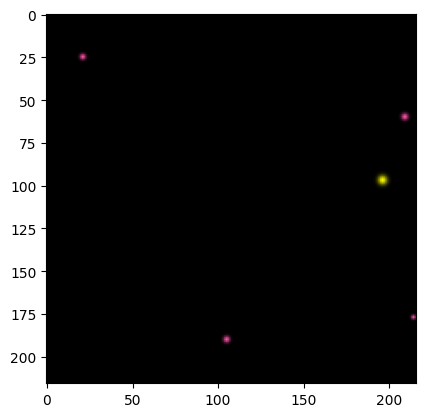

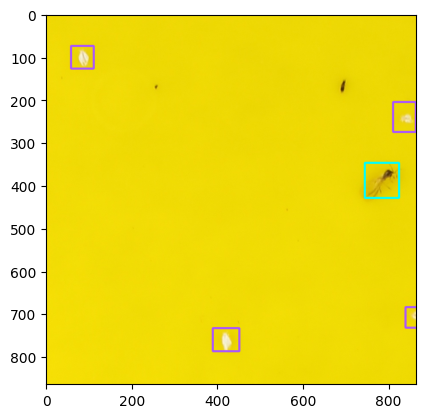

In [5]:
nx,ny = iw//4,ih//4

#y = encode(boxes, labels, nx , ny)
y = encodeTF(tf.constant(boxes, dtype=tf.float32), labels, nx, ny)
y = tf.expand_dims(y,0)

imgs = cv2.imread(imagFile)
imgs = imgs.astype(np.float32)/255.0
imgs = np.expand_dims(imgs,0)
imgs = tf.constant(imgs)


imgsAug = drawTF(imgs, y, thres=0.1, normalizedImage=True)

hms = drawHmTF(y)

for hm,img in zip(hms,imgsAug):
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

    print(tf.reduce_max(hm), tf.reduce_min(hm))
    print(hm.shape)
    plt.imshow(hm)
    plt.show()


    plt.imshow(img)
    plt.show()





